# TextCL Tutorial

1. [Filtering on language](#Filtering-on-language)
2. [Filtering on Jaccard similarity](#Filtering-on-Jaccard-similarity)
3. [Filtering on perplexity score](#Filtering-on-perplexity-score)
4. [Outliers filtering](#Outliers-filtering)
5. [Plots for outlier detection](#Plots-for-outlier-detection)

## Load package and dependencies

In [1]:
import textcl
import pandas as pd

## Prepare input data from modified the BBC dataset

Load the text data you want to process. It's necessary to have column `text` in the data (default name). If you don't have `text` column you will need to specify the name for [`split_into_sentences()`](https://alinapetukhova.github.io/textcl/docs/preprocessing.html#textcl.preprocessing.split_into_sentences) function using `text_col` parameter. Source file from this example structured as follows:

In [2]:
SOURCE_FILE_PATH = 'prepared_bbc_dataset.csv'

# getting text data from file
input_texts_df = pd.read_csv(SOURCE_FILE_PATH).reset_index()
input_texts_df

,index,topic_name,text
0,0,business,WorldCom bosses' $54m payout Ten former direc...
1,1,business,Profits slide at India's Dr Reddy Profits at ...
2,2,business,Liberian economy starts to grow The Liberian ...
3,3,business,"Uluslararası Para Fonu (IMF), Liberya ekonomis..."
4,4,entertainment,Singer Ian Brown 'in gig arrest' Former Stone...
5,5,entertainment,Blue beat U2 to top France honour Irish band ...
6,6,entertainment,Housewives lift Channel 4 ratings The debut o...
7,7,entertainment,Домохозяйки подняли рейтинги канала 4 Дебют ам...
8,8,entertainment,Housewives Channel 4 reytinglerini yükseltti A...
9,9,politics,Observers to monitor UK election Ministers wi...


## Split texts into sentences

If `sentence_col` is not specified as a parameter, created sentences will be saved in the `sentence` column.|

In [3]:
split_input_texts_df = textcl.split_into_sentences(input_texts_df)
print("Num sentences before filtering: {}".format(len(split_input_texts_df)))

Num sentences before filtering: 319


In [4]:
split_input_texts_df.head()

,index,topic_name,text,sentence
0,0,business,WorldCom bosses' $54m payout Ten former direc...,WorldCom bosses' $54m payout Ten former direc...
1,0,business,WorldCom bosses' $54m payout Ten former direc...,"James Wareham, a lawyer representing one of t..."
2,0,business,WorldCom bosses' $54m payout Ten former direc...,The remaining $36m will be paid by the directo...
3,0,business,WorldCom bosses' $54m payout Ten former direc...,"But, a spokesman for the prosecutor, New York ..."
4,0,business,WorldCom bosses' $54m payout Ten former direc...,Corporate governance experts said that if the...


## Filtering on language

The function [`language_filtering()`](https://alinapetukhova.github.io/textcl/docs/preprocessing.html#textcl.preprocessing.language_filtering) used to filter sentences by the language. Inputs to this function should be pandas data frame with sentence column, threshold value, and target language. Language score is the threshold used for filtering with the default value of 0.99. In the function was used the `detect_language` function from the package `langdetect`, that returns probabilities of text belonging to a certain language. All sentences below threshold will be filtered.

In [5]:
split_input_texts_df = textcl.language_filtering(split_input_texts_df, threshold=0.99, language='en')
print("Num sentences after language filtering: {}".format(len(split_input_texts_df)))

Num sentences after language filtering: 281


In [6]:
split_input_texts_df.head()

,index,topic_name,text,sentence
0,0,business,WorldCom bosses' $54m payout Ten former direc...,WorldCom bosses' $54m payout Ten former direc...
1,0,business,WorldCom bosses' $54m payout Ten former direc...,"James Wareham, a lawyer representing one of t..."
2,0,business,WorldCom bosses' $54m payout Ten former direc...,The remaining $36m will be paid by the directo...
3,0,business,WorldCom bosses' $54m payout Ten former direc...,"But, a spokesman for the prosecutor, New York ..."
4,0,business,WorldCom bosses' $54m payout Ten former direc...,Corporate governance experts said that if the...


Join sentences to the texts to review the results

In [7]:
textcl.join_sentences_by_label(split_input_texts_df, label_col = 'index')

,index,sentence
0,0,WorldCom bosses' $54m payout Ten former direc...
1,1,Profits slide at India's Dr Reddy Profits at ...
2,2,Liberian economy starts to grow The Liberian ...
3,4,Singer Ian Brown 'in gig arrest' Former Stone...
4,5,Blue beat U2 to top France honour Irish band ...
5,6,Housewives lift Channel 4 ratings The debut o...
6,9,Observers to monitor UK election Ministers wi...
7,10,Lib Dems highlight problem debt People vulner...
8,11,Minister defends hunting ban law The law bann...
9,12,Legendary Dutch boss Michels dies Legendary D...


As we can see texts with index 3 (Turkish), 7 (Russian), 8 (Turkish) were removed.

## Filtering on Jaccard similarity

Function [`jaccard_sim_filtering()`](https://alinapetukhova.github.io/textcl/docs/preprocessing.html#textcl.preprocessing.jaccard_sim_filtering) used to filter sentences by Jaccard similarity. Represents each sentence as an array of tokens and finds the intersection between two arrays. Using the intersection calculated the similarity score and if it's below the given threshold sentence will be filtered.

In [8]:
split_input_texts_df = textcl.jaccard_sim_filtering(split_input_texts_df, threshold=0.8)
print("Num sentences after Jaccard sim filtering: {}".format(len(split_input_texts_df)))

Num sentences after Jaccard sim filtering: 258


In [9]:
split_input_texts_df.head()

,index,topic_name,text,sentence
0,0,business,WorldCom bosses' $54m payout Ten former direc...,WorldCom bosses' $54m payout Ten former direc...
1,0,business,WorldCom bosses' $54m payout Ten former direc...,"James Wareham, a lawyer representing one of t..."
2,0,business,WorldCom bosses' $54m payout Ten former direc...,The remaining $36m will be paid by the directo...
3,0,business,WorldCom bosses' $54m payout Ten former direc...,"But, a spokesman for the prosecutor, New York ..."
4,0,business,WorldCom bosses' $54m payout Ten former direc...,Corporate governance experts said that if the...


Join sentences to the texts to review the results

In [10]:
textcl.join_sentences_by_label(split_input_texts_df, label_col = 'index')

,index,sentence
0,0,WorldCom bosses' $54m payout Ten former direc...
1,1,Profits slide at India's Dr Reddy Profits at ...
2,2,Liberian economy starts to grow The Liberian ...
3,4,Singer Ian Brown 'in gig arrest' Former Stone...
4,5,Blue beat U2 to top France honour Irish band ...
5,6,Housewives lift Channel 4 ratings The debut o...
6,9,Observers to monitor UK election Ministers wi...
7,10,Lib Dems highlight problem debt People vulner...
8,11,Minister defends hunting ban law The law bann...
9,12,Legendary Dutch boss Michels dies Legendary D...


Text with id=17 was removed as it partially duplicates text with id=18.

## Filtering on perplexity score

Function [`perplexity_filtering()`](https://alinapetukhova.github.io/textcl/docs/preprocessing.html#textcl.preprocessing.perplexity_filtering) used to filter sentences by perplexity. The first step creates contextual string embeddings to capture latent syntactic-semantic information. Embedding generation provided by the package `flair`. By default uses `news-forward` embeddings, that can be replaced with the mode specific embeddings based on the language and document scope.

In [11]:
split_input_texts_df = textcl.perplexity_filtering(split_input_texts_df, threshold=5)
print("Num sentences after perplexity filtering: {}".format(len(split_input_texts_df)))

Num sentences after perplexity filtering: 209


In [12]:
split_input_texts_df.head()

,index,topic_name,text,sentence
1,0,business,WorldCom bosses' $54m payout Ten former direc...,"James Wareham, a lawyer representing one of t..."
2,0,business,WorldCom bosses' $54m payout Ten former direc...,The remaining $36m will be paid by the directo...
3,0,business,WorldCom bosses' $54m payout Ten former direc...,"But, a spokesman for the prosecutor, New York ..."
4,0,business,WorldCom bosses' $54m payout Ten former direc...,Corporate governance experts said that if the...
5,0,business,WorldCom bosses' $54m payout Ten former direc...,"""Directors very rarely pay,"" said Charles Els..."


Join sentences to the texts to review the results

In [13]:
textcl.join_sentences_by_label(split_input_texts_df, label_col = 'index')

,index,sentence
0,0,"James Wareham, a lawyer representing one of t..."
1,1,Dr Reddy's has built its reputation on produci...
2,2,Liberian economy starts to grow The Liberian ...
3,4,Singer Ian Brown 'in gig arrest' Former Stone...
4,5,U2 received a special achievement prize at th...
5,6,Housewives lift Channel 4 ratings The debut o...
6,9,Observers to monitor UK election Ministers wi...
7,10,Lib Dems highlight problem debt People vulner...
8,11,The rural affairs minister said it would beco...
9,12,"Referred to in the Netherlands as ""the Genera..."


Text with id=19 was removed because sentence `data clear additional 78.0 long-term 43 those)` is not linguistically correct.

## Outliers filtering

The function [`outlier_detection()`](https://alinapetukhova.github.io/textcl/docs/outliers_detection.html#textcl.outliers_detection.outlier_detection) used to detect outliers in a list of sentences based on the contextual information using the unsupervised methods. Text embeddings were created as a bag of words as an input for the algorithms. Input parameters - Pandas data frames with texts, method to use for outlier detection, norm to normalize the obtained matrix and detect the abnormal texts.

Join sentences to the text after filtering and select category **tech**. In this category was manually inserted an outlier with person profile instead of tech text

In [14]:
joined_texts = split_input_texts_df[["index", "text", "topic_name"]].drop_duplicates()
joined_texts = joined_texts[joined_texts.topic_name == 'tech']

In [15]:
joined_texts, _ = textcl.outlier_detection(joined_texts, method='rpca', Z_threshold=0.8)
print("Num sentences after outliers filtering: {}".format(len(input_texts_df)))

Num sentences after outliers filtering: 21


[nltk_data] Downloading package stopwords to /home/alina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
joined_texts

,index,text,topic_name,words,Z_score
212,16,PlayStation 3 processor unveiled The Cell pro...,tech,PlayStation 3 processor unveiled Cell processo...,0.431154
233,18,PC photo printers challenge pros Home printed...,tech,PC photo printers challenge pros Home printed ...,0.292867


Text with id=20 was removed because it describes a person profile instead of tech news.


## Plots for outlier detection

In this block of tutorial we will visualize the outliers for the BBC data set obtained with the different algorithms

In [17]:
import os
from sklearn.feature_extraction.text import CountVectorizer
import random
from nltk.corpus import stopwords
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/alina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Prepare input data from the BBC dataset

In [18]:
dataset_path = "./datasets/bbc" # http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip
bbc_dataset = pd.DataFrame([], columns = ['class_name', 'text'])

list_topic_folders = os.listdir("{}/".format(dataset_path))
for topic_folder in list_topic_folders:
    if "txt" not in topic_folder.lower():
        list_of_files = os.listdir("{}/{}".format(dataset_path, topic_folder))
        for file in list_of_files:
            if file.find(".txt") != -1 and file.find("ipynb") == -1:
                with open("{}/{}/{}".format(dataset_path, topic_folder, file), 'rb') as f:
                    text = f.read()
                text = text.decode('windows-1252').replace('\n', ' ')
                bbc_dataset = bbc_dataset.append(pd.DataFrame([[topic_folder, text]], columns = ['class_name', 'text']))
bbc_dataset = bbc_dataset.reset_index(drop=True)

Get data for business and politics classes to form the core of the data set

In [19]:
bus_and_pol = bbc_dataset[(bbc_dataset['class_name'] == "business") | (bbc_dataset['class_name'] == "politics")]
df_bus_and_pol_texts = pd.DataFrame(list(bus_and_pol.text.values), columns=['text'])
df_bus_and_pol_texts['y_true'] = 0

Get 50 random outliers documents from tech class

In [20]:
text_for_outliers = bbc_dataset[bbc_dataset['class_name'] == "tech"]

random.seed(1)
text_for_outliers = text_for_outliers.iloc[random.sample(range(0, len(text_for_outliers)), 50)]
df_outliers = pd.DataFrame(list(text_for_outliers.text.values), columns=['text'])
df_outliers['y_true'] = 1

Add outliers documents to the core data set and shuffle

In [21]:
df_test = pd.concat([df_bus_and_pol_texts, df_outliers])
df_test = df_test.sample(frac=1).reset_index(drop=True)

stop = stopwords.words('english')

df_test['text'] = df_test['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_test

,text,y_true
0,Police chief backs drinking move A chief const...,0
1,Brown names 16 March Budget Chancellor Gordon ...,0
2,Cairn Energy Indian gas find Shares Cairn Ener...,0
3,US consumer confidence Consumers' confidence s...,0
4,UK heading wrong way - Howard Tony Blair chanc...,0
...,...,...
972,'No-one define new hunt ban' The new law banni...,0
973,'UK stand firm EU rebate' Britain's Â£3bn EU r...,0
974,Visa row mandarin made Sir John The top civil ...,0
975,"'Best person' top legal job The ""best person j...",0


Convert texts to the bag of words

In [22]:
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(df_test['text']).todense()

## TONMF

The function [`tonmf()`](https://alinapetukhova.github.io/textcl/docs/outliers_detection.html#textcl.outliers_detection.tonmf) to use TONMF algorithm to get the outlier\_matrix. Solution is based on the non-negative matrix factorization with the extension of the block coordinate descent framework

In [23]:
outlier_matrix,_,_,_ = textcl.tonmf(bag_of_words, k=10, alpha=10, beta=0.05)

Normalize with l2-normalization

Text(0.5, 1.0, 'BBC dataset TONMF ROC-curve. K=3, alpha = 1, beta = 0.5')

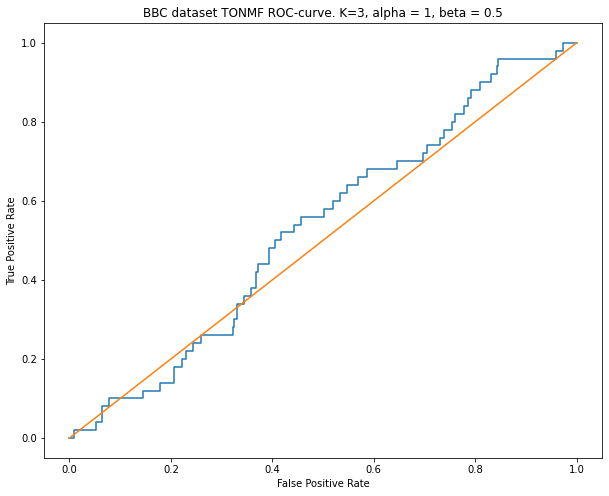

In [24]:
_, y_pred = preprocessing.normalize(outlier_matrix, axis = 1, norm = 'l2', return_norm = True)

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(list(df_test['y_true'].values), y_pred, pos_label=1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BBC dataset TONMF ROC-curve. K=3, alpha = 1, beta = 0.5')

Display ℓ2 norm of columns of Z outlier matrix

Text(0.5, 1.0, 'Results of TONMF+L2 (outliers - red, non-outliers - blue)')

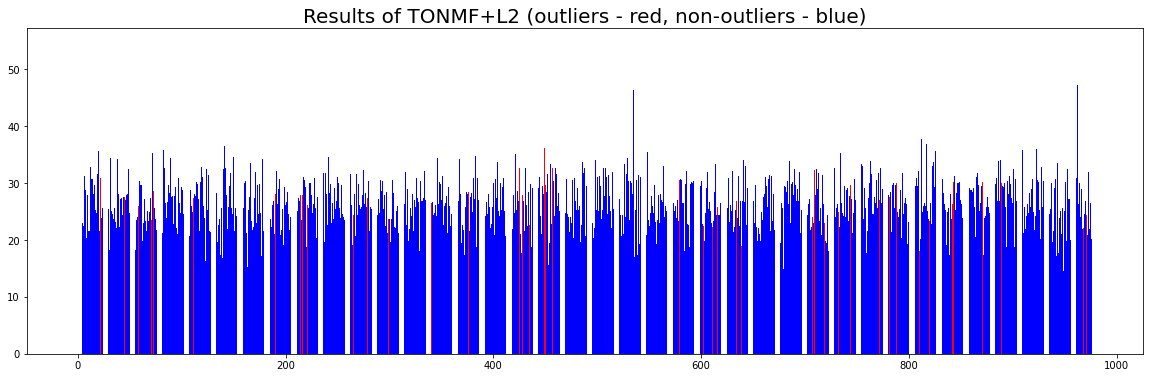

In [25]:
colors_array = np.array(list(df_test['y_true'].values)).astype('str')
colors_array[colors_array == '1'] = 'r'
colors_array[colors_array != 'r'] = 'b'

plt.figure(figsize=(20, 6))
index = range(0, len(y_pred))
plt.bar(index, y_pred, color = colors_array)
plt.title("Results of TONMF+L2 (outliers - red, non-outliers - blue)", size = 20)

## RPCA

Function [`rpca_implementation()`](https://alinapetukhova.github.io/textcl/docs/outliers_detection.html#textcl.outliers_detection.rpca_implementation) to use Robust Principal Component Analysis (RPCA) to get the outlier\_matrix. RPCA uses low rank approximation and yields two matrices: low rank matrix $L$ and a sparse matrix $S$. After normalization, the $S$ matrix represents the outlier score for the document.

In [26]:
outlier_matrix = textcl.rpca_implementation(bag_of_words)

Normalize with l2-normalization

Text(0.5, 1.0, 'BBC dataset RPCA ROC-curve')

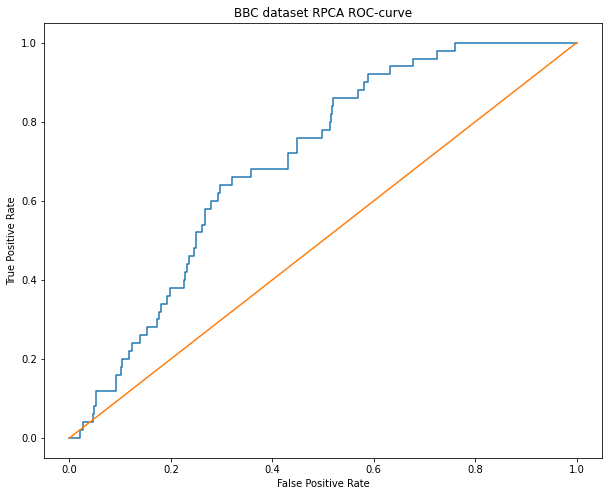

In [27]:
_, y_pred = preprocessing.normalize(outlier_matrix, axis = 1, norm = 'l2', return_norm = True)

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(list(df_test['y_true'].values), y_pred, pos_label=1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BBC dataset RPCA ROC-curve')

Display ℓ2 norm of columns of Z outlier matrix

Text(0.5, 1.0, 'Results of RPCA+L2 (outliers - red, non-outliers - blue)')

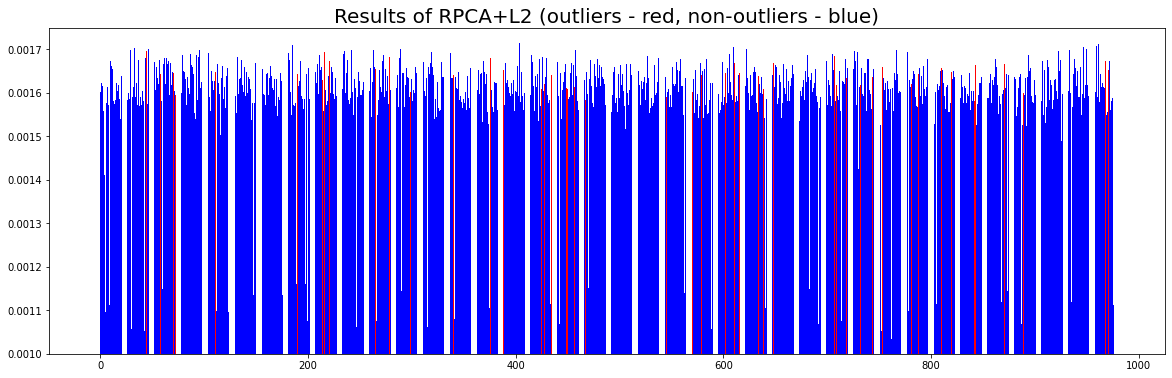

In [28]:
colors_array = np.array(list(df_test['y_true'].values)).astype('str')
colors_array[colors_array == '1'] = 'r'
colors_array[colors_array != 'r'] = 'b'

plt.figure(figsize=(20, 6))
plt.ylim(0.001, 0.00175)
index = range(0, len(y_pred))
plt.bar(index, y_pred, color = colors_array)
plt.title("Results of RPCA+L2 (outliers - red, non-outliers - blue)", size = 20)

## SVD

Function [`svd()`](https://alinapetukhova.github.io/textcl/docs/outliers_detection.html#textcl.outliers_detection.svd) to use singular value decomposition (SVD) to get the outlier_matrix. SVD function used from `np.linalg` and outlier matrix is presented as multiplication of square root of diagonal elements of the rectangular diagonal matrix $S$ and complex unitary matrix

In [29]:
outlier_matrix = textcl.svd(bag_of_words)

Normalize with l2-normalization

Text(0.5, 1.0, 'BBC dataset SVD ROC-curve')

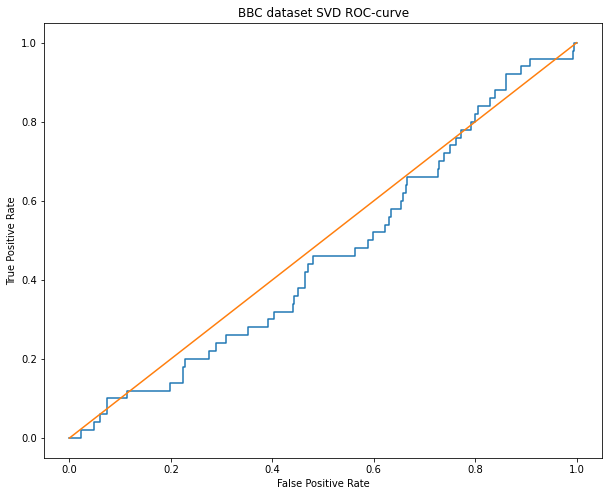

In [30]:
_, y_pred = preprocessing.normalize(outlier_matrix, axis = 1, norm = 'l2', return_norm = True)

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = metrics.roc_curve(list(df_test['y_true'].values), y_pred, pos_label=1)
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BBC dataset SVD ROC-curve')

Display ℓ2 norm of columns of Z outlier matrix

Text(0.5, 1.0, 'Results of SVD+L2 (outliers - red, non-outliers - blue)')

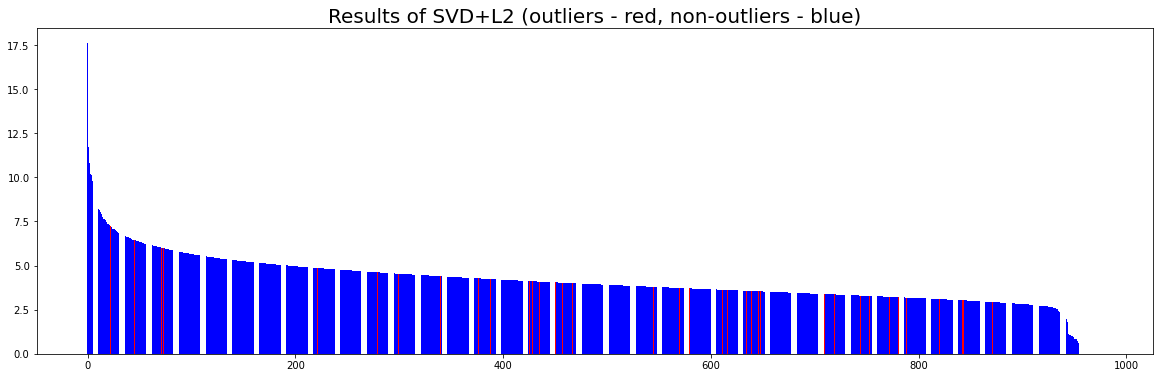

In [31]:
colors_array = np.array(list(df_test['y_true'].values)).astype('str')
colors_array[colors_array == '1'] = 'r'
colors_array[colors_array != 'r'] = 'b'

plt.figure(figsize=(20, 6))
# plt.ylim(0.001, 0.00175)
index = range(0, len(y_pred))
plt.bar(index, y_pred, color = colors_array)
plt.title("Results of SVD+L2 (outliers - red, non-outliers - blue)", size = 20)


